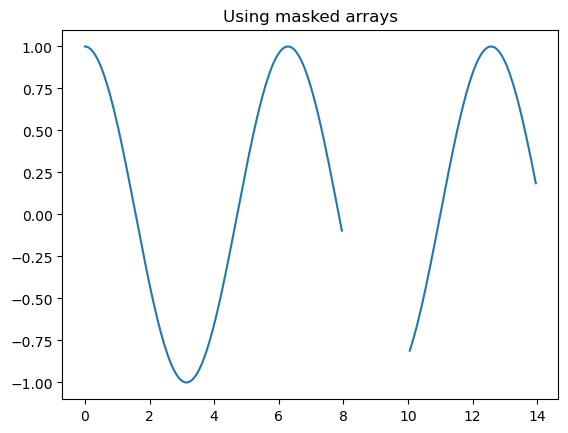

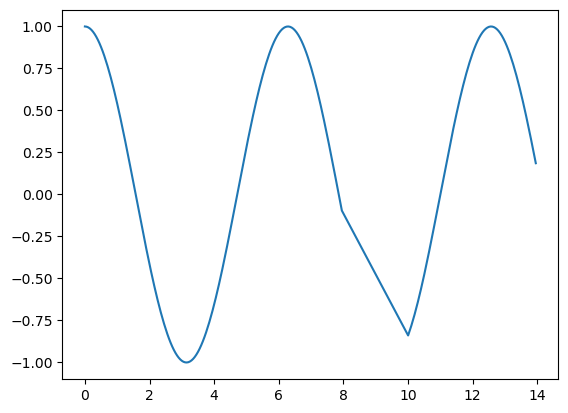

In [1]:

# Masked arrays work well for this. You just need to mask the first of the points you don't want to connect:

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

t1 = np.arange(0, 8, 0.05)
mask_start = len(t1)
t2 = np.arange(10, 14, 0.05)
t = np.concatenate([t1, t2])
c = np.cos(t)     # an aside, but it's better to use numpy ufuncs than list comps

mc = ma.array(c)
mc[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc)
plt.title('Using masked arrays')
plt.show()
plt.plot(t, c)

plt.show()

In [1]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import wandb

from dawgz import job, after, ensure, schedule
from itertools import chain, islice
from pathlib import Path
from torch import Tensor
Tensor
from tqdm import tqdm
from typing import *
import pandas as pd

from lampe.data import H5Dataset
from zuko.distributions import BoxUniform
from lampe.inference import NPE, NPELoss
from lampe.nn import ResMLP
from zuko.flows import NAF, NSF, MAF, NCSF, SOSPF, UNAF, CNF 
from lampe.plots import nice_rc, corner, coverage_plot, mark_point
from lampe.utils import GDStep

import sys
sys.path.insert(0, '/home/mvasist/Highres/simulations/')
from DataProcuring import Data 
from ProcessingSpec import ProcessSpec
from parameter import *
from spectra_simulator import SpectrumMaker
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal
# from spectra_simulator import Simulator, LOWER, UPPER
# from AverageEstimator import avgestimator

# sys.path.insert(0, '/home/mvasist/Highres/sbi/added_scripts/')
from added_scripts.corner_modified import *
from added_scripts.pt_plotting import *


# from ees import Simulator, LOWER, UPPER, LABELS, pt_profile
LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
# [                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
# [                  r'$fsed$',  0.0, 10.0],   # temp_node_8
# [                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
# [                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  10.0, 30.0], # NH3_mol_scale 20, 35
[                  r'$vsini$', 0.0, 50 ], # H2S_mol_scale 10.0, 30.0
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
[                  r'$b$',  1, 20.0], # PH3_mol_scale

])

os.environ['SCRATCH'] = os.path.join('/scratch/users/mvasist/')
scratch = os.environ['SCRATCH']
datapath = Path(scratch) / 'highres-sbi/data_nic5'
runpath = Path(scratch) / 'highres-sbi/runs/sweep_lognormnoise'

processing = ProcessSpec()
d = Data()
sim = SpectrumMaker(wavelengths=d.model_wavelengths, param_set=param_set, lbl_opacity_sampling=2)


def simulator(theta):
    values = theta[:-4].numpy()
    values_ext = theta[-4:].numpy()
    # print(values, values_ext)
    values_actual = deNormVal(values, param_list)
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), d.model_wavelengths))
    
    values_ext_actual = deNormVal(values_ext, param_list_ext)
    # params_ext = param_set_ext.param_dict(values_ext_actual)
    
    th, x = processing(torch.Tensor([values_actual]), torch.Tensor(spec), sample= False, \
                       values_ext_actual= torch.Tensor([values_ext_actual]))
    # print(np.shape(x))
    return x.squeeze()


## Loading from a model to plot
CONFIGS = {
    'embedding': ['shallow'],
    'flow': ['MAF'],  #, 'NCSF', 'SOSPF', 'UNAF', 'CNF'], #'NAF', 
    'transforms': [3], #, 7], #3, 
    # 'signal': [16, 32],  # not important- the autoregression network output , 32
    'hidden_features': [512], # hidden layers of the autoregression network , 256, 
    'hidden_features_no' : [5], 
    'activation': [nn.ELU], #, nn.ReLU],
    'optimizer': ['AdamW'],
    'init_lr':  [1e-3], #[5e-4, 1e-5]
    'weight_decay': [1e-4], #[1e-4], #
    'scheduler': ['ReduceLROnPlateau'], #, 'CosineAnnealingLR'],
    'min_lr': [1e-5], # 1e-6
    'patience': [16], #8
    'epochs': [350],
    'stop_criterion': ['early'], #, 'late'],
    'batch_size':  [256],
    'spectral_length' : [6144], #[1536, 3072, 6144]
    'factor' : [0.3], 
    'noise_scaling' : [2], 
    'noise' : ['lognormaldist']
    # 'SOSF_degree' : [2,3,4],
    # 'SOSF_poly' : [2,4,6],
}



DataProcuring
False


/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

False
  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



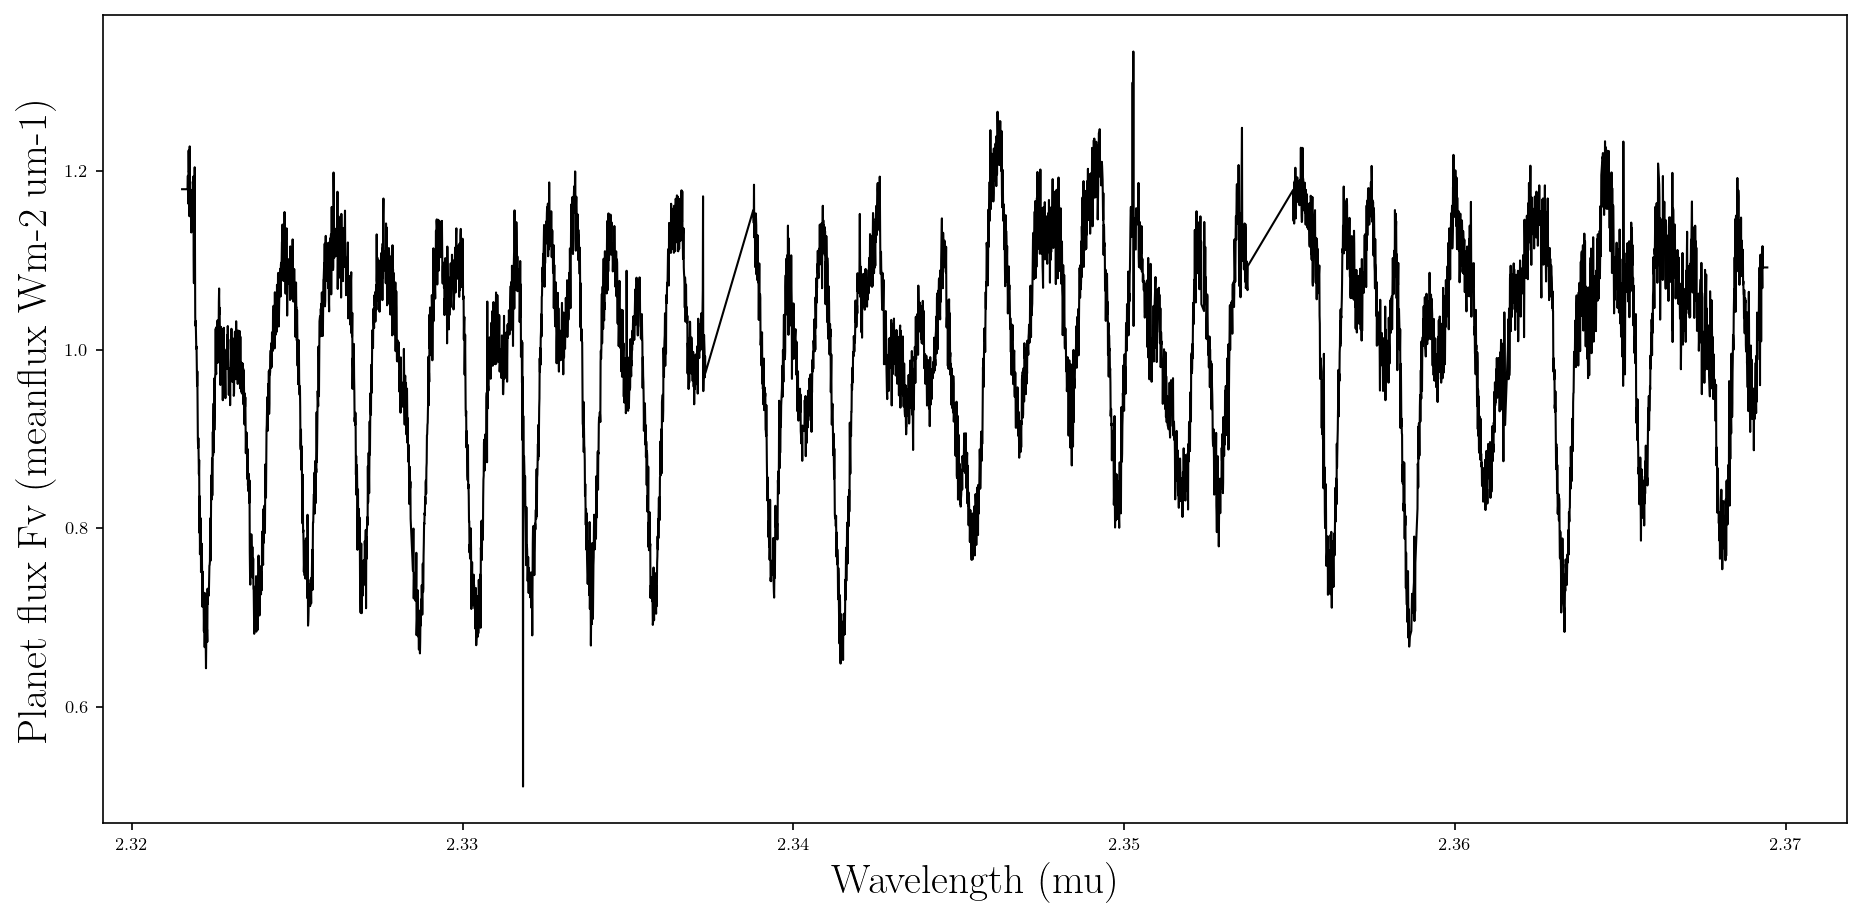

In [2]:
## Observations

def data_loading():
        return torch.from_numpy(d.flux*d.flux_scaling)

fl =  data_loading()
wlength = d.data_wavelengths   
    
plt.rcParams.update(nice_rc(latex=True))
plt.figure(figsize=(15,7))
plt.plot(wlength, fl, color = 'black')
plt.xlabel('Wavelength (mu)', fontsize = 20)
plt.ylabel('Planet flux Fv (meanflux Wm-2 um-1)', fontsize= 20)
plt.show()

data_uncertainty = d.err * d.flux_scaling
data_uncertainty = torch.from_numpy(data_uncertainty)



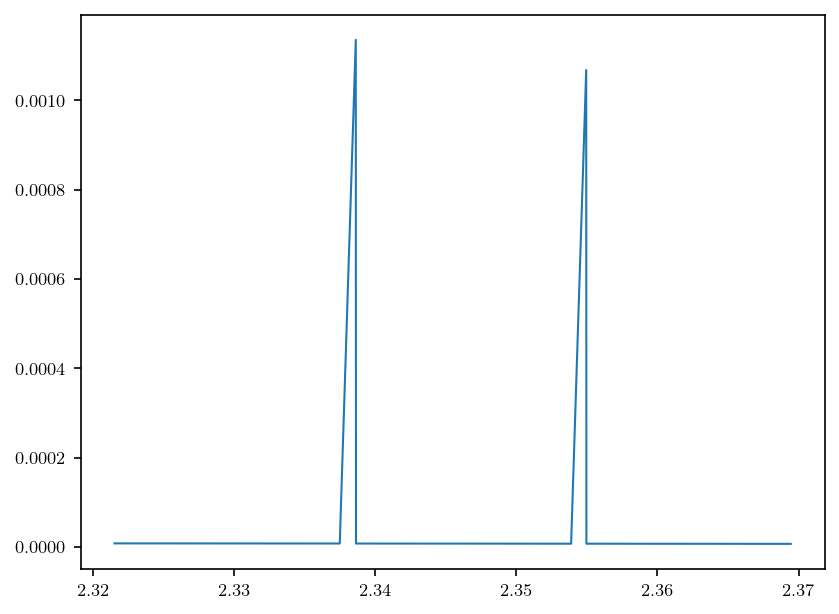

In [3]:
plt.plot(d.data_wavelengths[1:], np.diff(d.data_wavelengths))
plt.show()

In [4]:
np.where(np.diff(d.data_wavelengths)> 0.0002 )[0]

array([2047, 4095])

In [36]:
data = Path(scratch) / 'highres-sbi/data_nic5'
trainset = H5Dataset(data / 'train.h5', batch_size=16, shuffle=True)
validset = H5Dataset(data / 'valid.h5', batch_size=16, shuffle=True)
testset = H5Dataset(data / 'test.h5', batch_size=16, shuffle=True)

for th, x in testset:
    print(th.size(), x.size())

torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size([16, 6144])
torch.Size([16, 19]) torch.Size(

In [5]:
import numpy.ma as ma

wave = ma.array(wlength)
flux = ma.array(fl)

mask_indices = [2047, 4095]

wave[mask_indices] = ma.masked
flux[mask_indices] = ma.masked

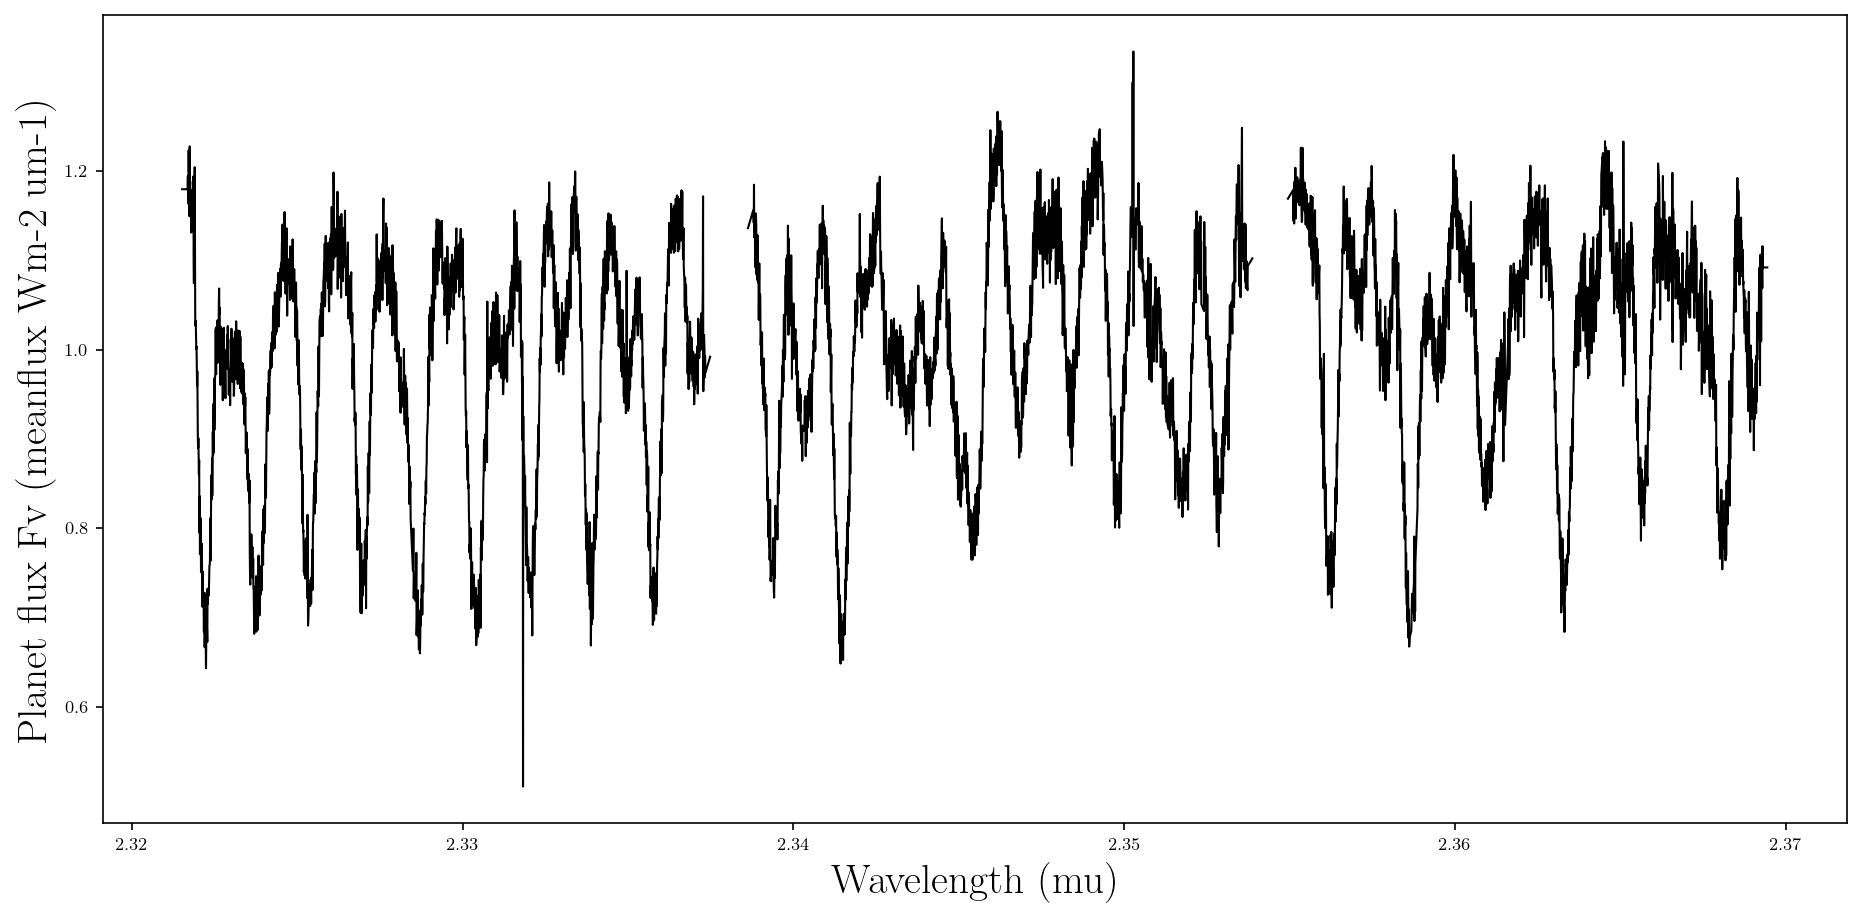

In [6]:
plt.rcParams.update(nice_rc(latex=True))
plt.figure(figsize=(15,7))
plt.plot(wave, flux, color = 'black')
plt.xlabel('Wavelength (mu)', fontsize = 20)
plt.ylabel('Planet flux Fv (meanflux Wm-2 um-1)', fontsize= 20)
plt.show()

In [7]:
def return_tchvalues_from_files(path):
    df_v = pd.read_csv(path)
    v = df_v.values
    v = torch.from_numpy(v)
    
    return v

def save_tchvalues_to_files(path, v):
    df_v = pd.DataFrame(v) #convert to a dataframe
    df_v.to_csv(path,index=False) #save to file
    
    return print('saved')

In [27]:
scratch = os.environ.get('SCRATCH', '')

ep = 900
savepath = runpath / 'honest-totem-81'
savepath_plots = savepath / ('plots_' + str(ep))


In [17]:
CONFIGS = {
    'embedding': ['deep'],
    'flow': ['MAF'],  #, 'NCSF', 'SOSPF', 'UNAF', 'CNF'], #'NAF', 
    'transforms': [7], #, 7], #3, 
    # 'signal': [16, 32],  # not important- the autoregression network output , 32
    'hidden_features': [256], # hidden layers of the autoregression network , 256, 
    'hidden_features_no' : [5], 
    'activation': [nn.ELU], #, nn.ReLU],
    'optimizer': ['AdamW'],
    'init_lr':  [1e-3], #[5e-4, 1e-5]
    'weight_decay': [1e-3], #[1e-4], #
    'scheduler': ['ReduceLROnPlateau'], #, 'CosineAnnealingLR'],
    'min_lr': [1e-6], # 1e-6
    'patience': [32], #8
    'epochs': [500],
    'stop_criterion': ['early'], #, 'late'],
    'batch_size':  [1024],
    'spectral_length' : [6144], #[1536, 3072, 6144]
    'factor' : [0.5], 
    # 'noise_scaling' : [2], 
    'noise' : ['lognormaldist'], 
    'ndim' : [20],
    # 'SOSF_degree' : [2,3,4],
    # 'SOSF_poly' : [2,4,6],
}

config = {
        key: random.choice(values)
        for key, values in CONFIGS.items()
    }


class NPEWithEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

        # Estimator
        if config['embedding'] == 'shallow':
            self.embedding = ResMLP(6144, 64, hidden_features=[512] * 2 + [256] * 3 + [128] * 5, activation= nn.ELU)
        else:
            self.embedding = ResMLP(6144, 128, hidden_features=[512] * 3 + [256] * 5 + [128] * 7, activation= nn.ELU)

        if config['flow'] == 'NCSF':
            self.npe = NPE(
                19, self.embedding.out_features,
                # moments=((l + u) / 2, (l - u) / 2),
                transforms=config['transforms'],
                build=NCSF,
                bins=config['signal'],
                hidden_features=[config['hidden_features']] * config['hidden_features_no'],
                activation=config['activation'],
            )
        elif config['flow'] == 'MAF':
            self.npe = NPE(
                config['ndim'], self.embedding.out_features,
                # moments=((l + u) / 2, (l - u) / 2),
                transforms=config['transforms'],
                build=MAF,
                # bins=config['signal'],
                hidden_features=[config['hidden_features']] * config['hidden_features_no'],
                activation=config['activation'],
            )


        elif config['flow'] == 'SOSPF':
                self.npe = NPE(
                19, self.embedding.out_features,
                # moments=((l + u) / 2, (l - u) / 2),
                transforms=config['transforms'],
                build=SOSPF,
                degree = config['SOSF_degree'],
                polynomials = config['SOSF_poly'],
                # signal=config['signal'],
                # hidden_features=[config['hidden_features']] * config['hidden_features_no'],
                # activation=config['activation'],
            )

        elif config['flow'] == 'UNAF':
                self.npe = NPE(
                19, self.embedding.out_features,
                # moments=((l + u) / 2, (l - u) / 2),
                transforms=config['transforms'],
                build=UNAF,
                signal=config['signal'],
                hidden_features=[config['hidden_features']] * config['hidden_features_no'],
                activation=config['activation'],
            )

        elif config['flow'] == 'CNF':
                self.npe = NPE(
                19, self.embedding.out_features,
                # moments=((l + u) / 2, (l - u) / 2),
                transforms=config['transforms'],
                build=CNF,
                # signal=config['signal'],
                # hidden_features=[config['hidden_features']] * config['hidden_features_no'],
                # activation=config['activation'],
            )


    # def forward(self, theta: Tensor, x: Tensor) -> Tensor:
    def forward(self, theta, x): # -> Tensor:
        y = self.embedding(x)
        return self.npe(theta, y)

    # def flow(self, x: Tensor):  # -> Distribution
    def flow(self, x):  # -> Distribution
        out = self.npe.flow(self.embedding(x)) #.to(torch.double)) #
        return out

estimator = NPEWithEmbedding()#.double().cuda()


In [31]:
states = torch.load(savepath / ('states_' + str(500) + '.pth'), map_location='cpu')
estimator.load_state_dict(states['estimator'])
estimator.double()#.cuda().eval()

NPEWithEmbedding(
  (embedding): ResMLP(
    (0): Linear(in_features=6144, out_features=512, bias=True)
    (1): Residual(MLP(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
    ))
    (2): Residual(MLP(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
    ))
    (3): Residual(MLP(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=512, out_features=512, bias=True)
    ))
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Residual(MLP(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (6): Residual(MLP(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): 

In [28]:
thetamhg_ = return_tchvalues_from_files(savepath_plots/'theta_256_noisy.csv')
xmhg_ = return_tchvalues_from_files(savepath_plots / 'x_256_noisy.csv')

thetahgm = return_tchvalues_from_files(savepath_plots/'theta.csv')

flux_postsamples_noisy = ma.array(xmhg_)

mask_indices = [2047, 4095]

flux_postsamples_noisy[:,mask_indices] = ma.masked

# theta = theta*(torch.Tensor(UPPER)-torch.Tensor(LOWER)) + torch.Tensor(LOWER)


In [33]:
estimator.flow(xmhg_)

NormalizingFlow(
  (transform): ComposedTransform(
    (0): AutoregressiveTransform()
    (1): AutoregressiveTransform()
    (2): AutoregressiveTransform()
    (3): AutoregressiveTransform()
    (4): AutoregressiveTransform()
    (5): AutoregressiveTransform()
    (6): AutoregressiveTransform()
  )
  (base): DiagNormal(loc: torch.Size([512, 20]), scale: torch.Size([512, 20]))
)

In [34]:
xmhg_.size()

torch.Size([512, 6144])

In [11]:
np.shape(flux_postsamples_noisy), np.shape(xmhg_)

((512, 6144), torch.Size([512, 6144]))

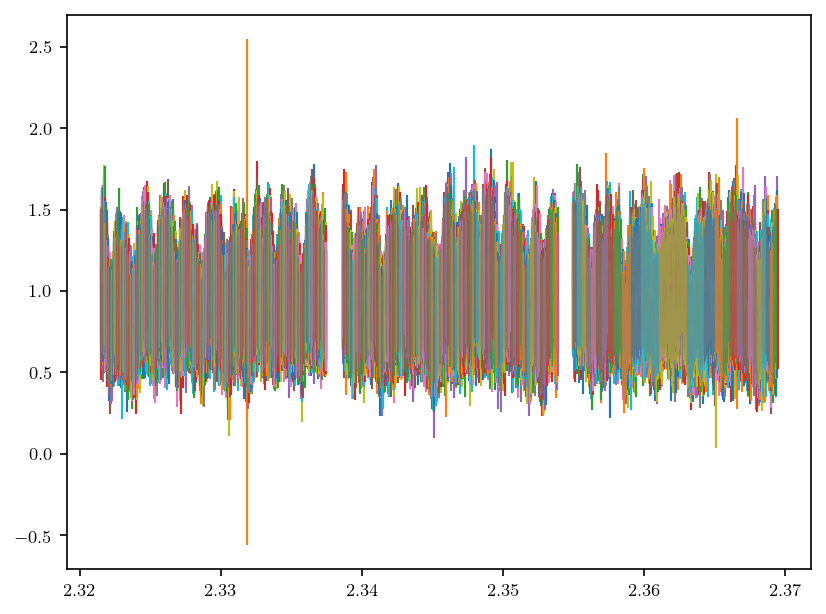

In [12]:
plt.plot(np.broadcast_to(wave, (512,6144)), flux_postsamples_noisy)
plt.show()

In [12]:
# def noisy(x, b= None): #50 is 10% of the median of the means of spectra in the training set.
#     bs = x.size()[0]
    
#     if b == None: 
#         if config['noise'] == 'uniformdist' :
#             b = 1  + torch.rand(bs) * (10-1)
#             b = torch.unsqueeze(b,1)
#         elif config['noise'] == 'lognormaldist' :
#             m = torch.distributions.log_normal.LogNormal(torch.tensor([1.5]), torch.tensor([0.5]))
#             b = m.sample([bs])
#     else: 
#         b = torch.unsqueeze(b, 1)
#         # print(b.size())

#     x = x + torch.mul(data_uncertainty * b.cuda() , torch.randn_like(x))
#     return x, b

# _, sigmam_new = noisy(xmhg_, thetamhg_[:,-1])

residuals_new = torch.from_numpy(flux_postsamples_noisy*d.flux_scaling - flux) / (torch.Tensor(data_uncertainty)*torch.unsqueeze(thetamhg_[:,-1].cpu(),1))

    

/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


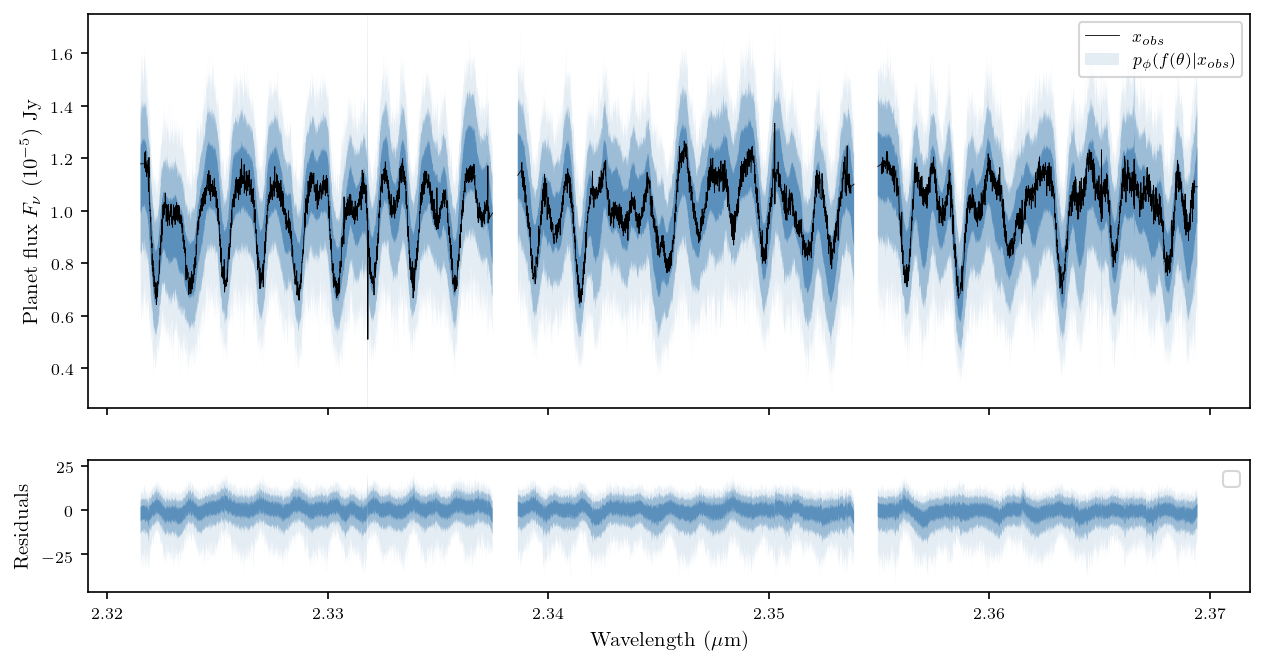

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes

params = {
        'axes.labelsize': 12,
          'legend.fontsize': 10, 
          'xtick.labelsize': 8, 'ytick.labelsize': 8}
plt.matplotlib.rcParams.update(params)


fig, (ax1, ax2) = plt.subplots(2, figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})
creds= [0.997, 0.955, 0.683]
alpha = (0.0, 0.9)
levels, creds = levels_and_creds(creds= creds, alpha = alpha)
cmap= LinearAlphaColormap('steelblue', levels=creds, alpha=alpha)

for q, l in zip(creds[:-1], levels):
        lower, upper = np.quantile(flux_postsamples_noisy, [0.5 - q / 2, 0.5 + q / 2], axis=0)
        ax1.fill_between(wave, lower, upper, color= cmap(l), linewidth=0) #'C0', alpha=0.4,

lines = ax1.plot(wave, flux, color='black', label = r'$ f(\theta_{obs})$', linewidth = 0.4)
handles, texts = legends(axes= ax1, alpha=alpha) #0.15, 0.75
texts = [r'$ x_{obs}$', r'$p_{\phi}(f(\theta)|x_{obs})$']

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel(r'Planet flux $F_\nu$ (10$^{-5}$) Jy', fontsize = 10)
ax1.legend(handles, texts, prop = {'size': 8}, bbox_to_anchor=(1,1))

ax1.set_ylim(0.25, 1.75)

# residuals = (x_256_noisy - x_star.cpu()) / (torch.Tensor(d.err*d.flux_scaling)*theta_star[-1].cpu())
residuals = (flux_postsamples_noisy - flux) / ((d.err*d.flux_scaling) * np.expand_dims(flux_postsamples_noisy[:,-1],axis=1))


for q, l in zip(creds[:-1], levels):
    lower, upper = np.quantile(residuals, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax2.fill_between(wave, lower, upper, color= cmap(l) , linewidth=0) 
ax2.set_ylabel(r'Residuals', fontsize = 10)
ax2.set_xlabel( r'Wavelength ($\mu$m)', fontsize = 10)



plt.legend()
plt.show()

## Corner


In [28]:
# thetamhg_ = return_tchvalues_from_files(savepath/'theta_256_noisy.csv')
# xmhg_ = return_tchvalues_from_files(savepath / 'x_256_noisy.csv')

ep = 1
runpath = savepath / 'logNormnoise_0'/ ('plots_' + str(ep))

thetahgm = return_tchvalues_from_files(runpath/'theta.csv')

# start = time()

corner_fig = corner_mod([thetahgm[:2000]], legend=['NPE'], \
                            color= ['steelblue'] , figsize=(20,20), \
                        domain = (LOWER, UPPER), labels= LABELS, \
                            labelsize = 20, legend_fontsize = 22,\
                   xtick_labelsize = 18 , ytick_labelsize = 18,) #

# corner_fig.savefig(self.savepath_plots / 'corner.pdf')
    
# end = time()

# print(end-start)

/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/numpy/lib/histograms.py:1125: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/numpy/lib/histograms.py:907: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/mvasist/miniconda3/envs/HighResear/lib/python3.9/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: Filled contours require at least 2 levels.

-1.5 1.5


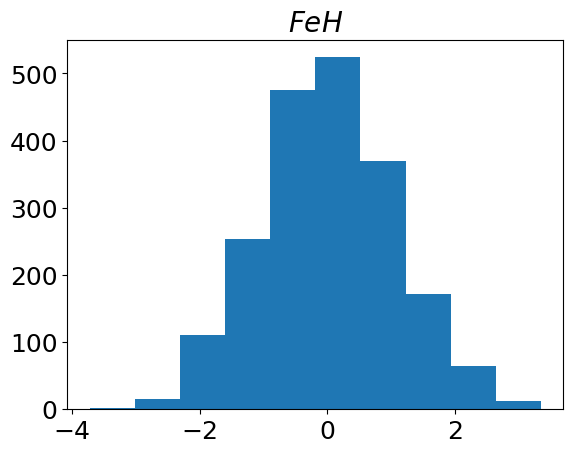

0.1 1.6


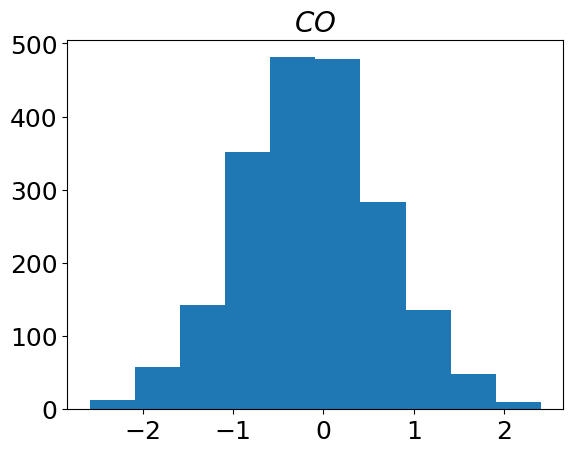

2.5 5.5


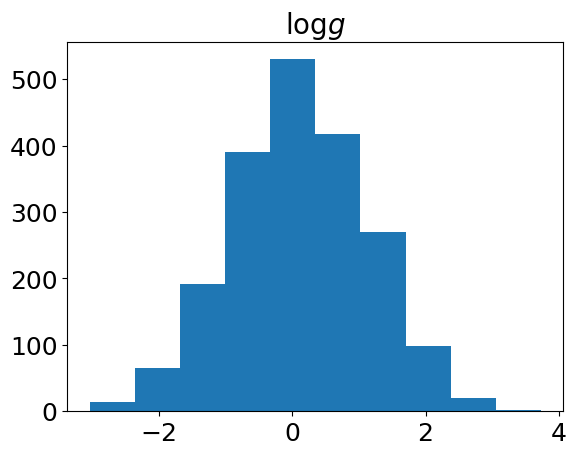

300 3500


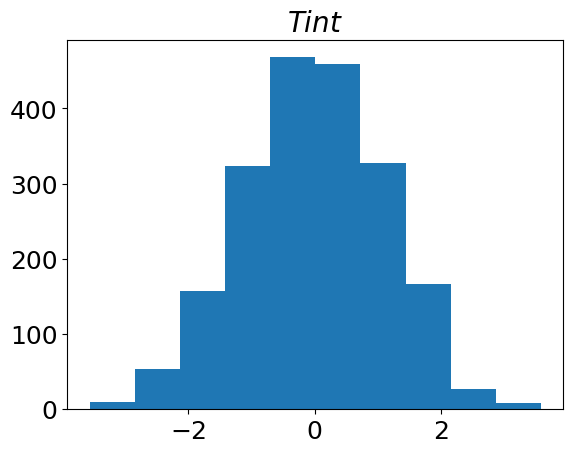

300 3500


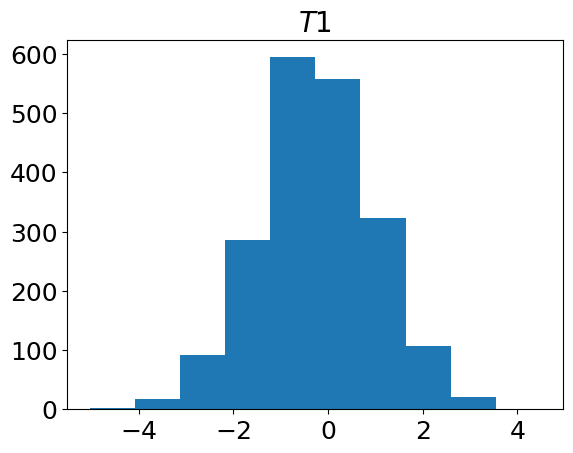

300 3500


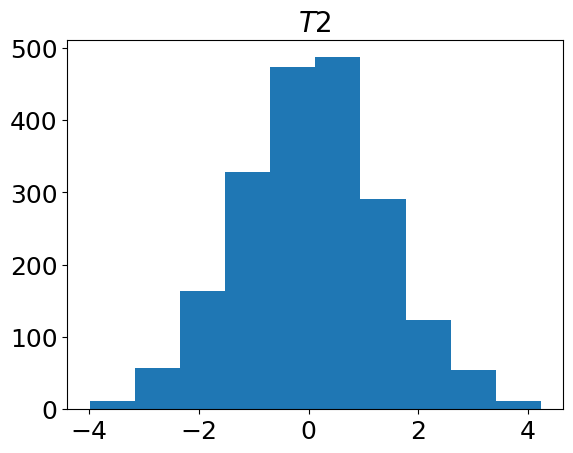

300 3500


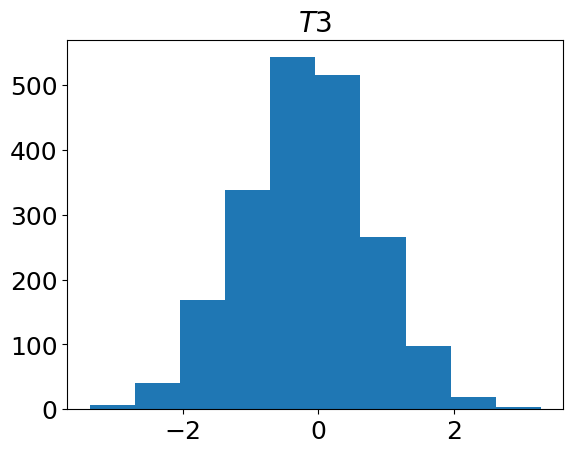

1.0 2.0


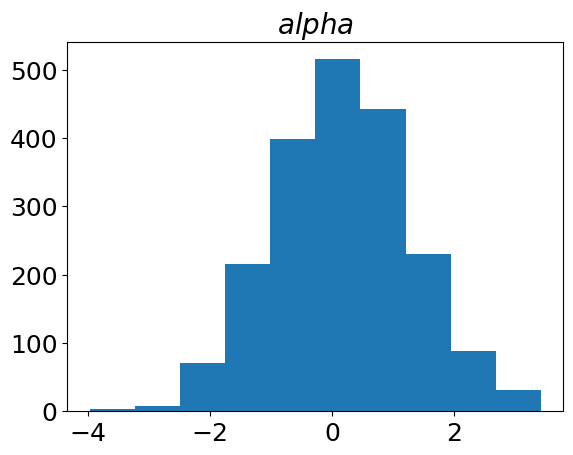

3.0 8.0


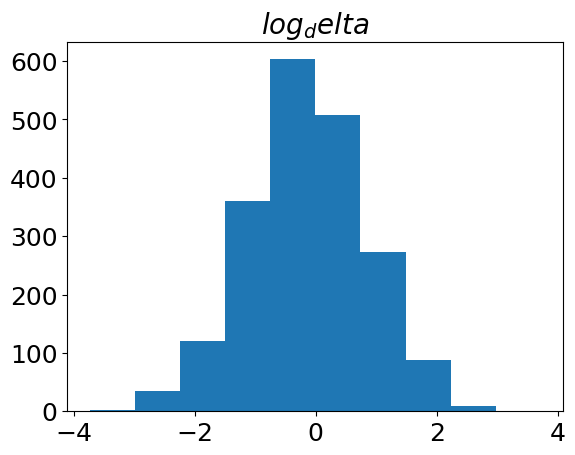

-6.0 3.0


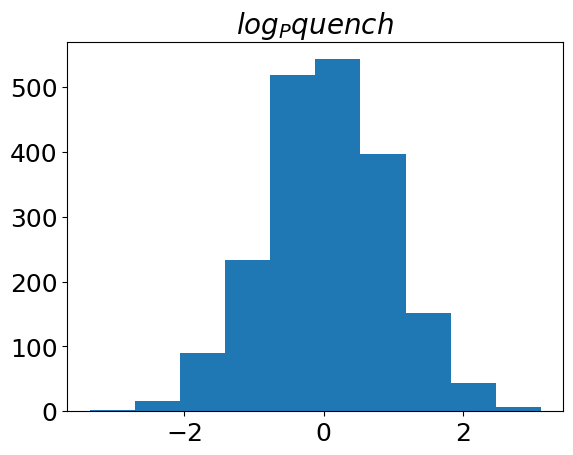

-11.0 -1.0


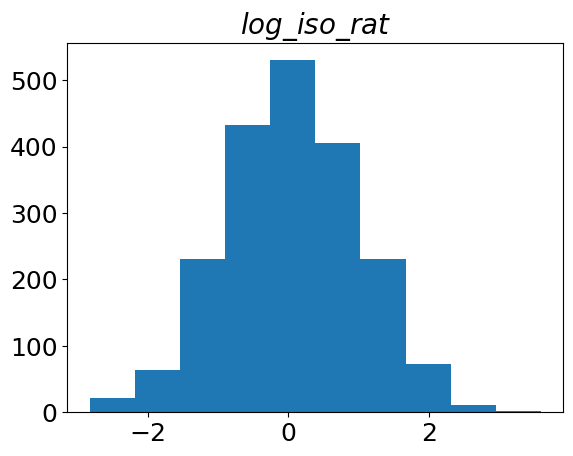

0.8 2.0


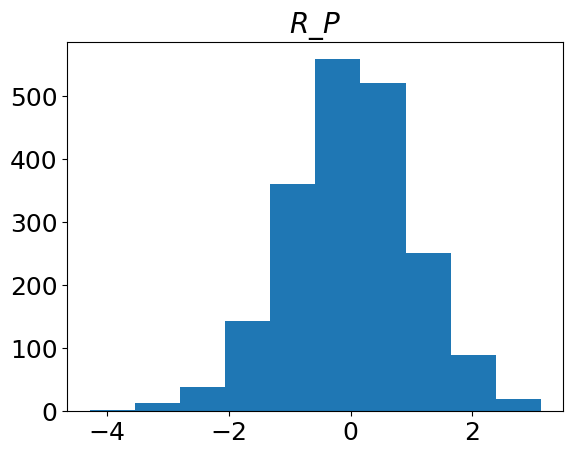

10.0 30.0


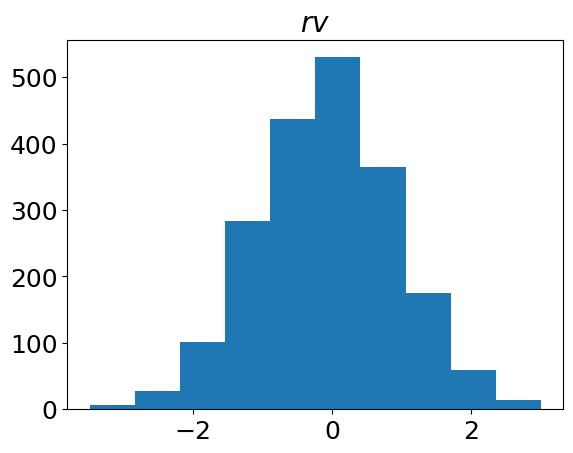

0.0 50


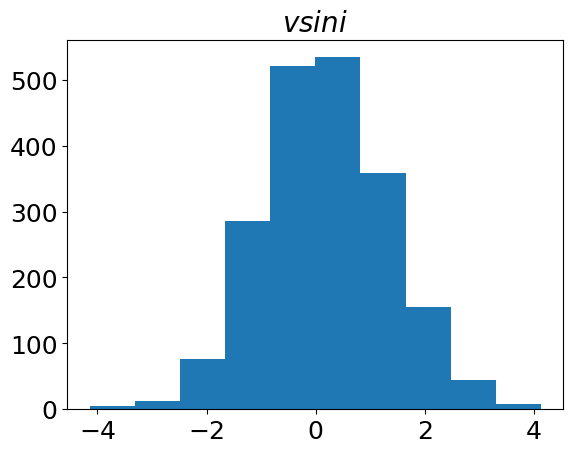

0.0 1.0


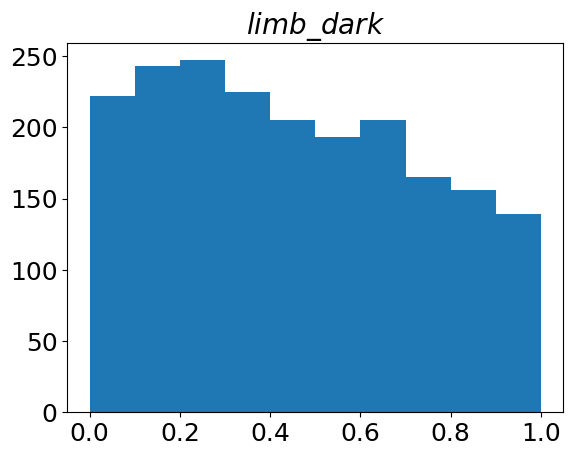

1 20.0


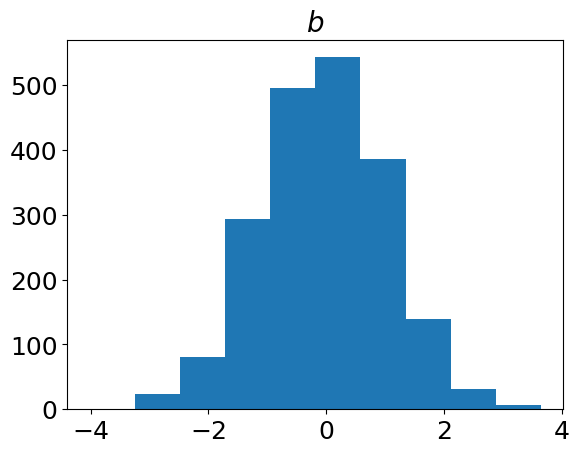

In [36]:

for i in range(16):
    print(LOWER[i], UPPER[i])
    plt.title(LABELS[i])
    plt.hist(thetahgm[:2000, i].numpy())
    plt.show()


In [35]:
LOWER[i]

-1.5

In [37]:

   
def thetascalebackup(theta):
    theta[:-1] =  torch.Tensor(LOWER[:-1]) + theta[:-1] * (torch.Tensor(UPPER[:-1]) - torch.Tensor(LOWER[:-1]))
    return theta


th_scaled = thetascalebackup(thetahgm[:2000])

RuntimeError: The size of tensor a (16) must match the size of tensor b (15) at non-singleton dimension 1

In [39]:
thetahgm[-1]

tensor([ 1.7081, -0.6032,  2.1170, -0.6586, -1.8912, -1.3272, -0.4697, -0.5821,
        -1.7330,  1.0473,  0.2556,  0.0988, -0.5687, -0.1170,  0.5510,  0.0998],
       dtype=torch.float64)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.